# Análisis para integrar C++ y Python
Dado que la librería `cppyy` no resultó tan eficiente comparada con otros métodos, se optó por evaluar distintas alternativas que permitan esta integración entre estos dos lenguajes. Estas alternativas fueron las siguientes:

- `ctypes`
- `Cython`
- `PyPy`

Para esto se utilizaron algunas funciones auxiliares utilizadas anteriormente.

In [4]:
import random
import numpy as np

def populate_list(n: int) -> list[float]:
    arr = []

    for _ in range(n):
        arr.append(random.uniform(-99.0, -99.5))
        arr.append(random.uniform(19.3, 19.5))

    return arr

def populate_array(n: int):
    list = populate_list(n)
    DoubleArray = ctypes.c_double * (n*2)
    return DoubleArray(*list)

def populate_vector(n: int):
    list = populate_list(n)
    data_array = np.array(list, dtype=np.float64)
    return memoryview(data_array)

In [12]:
import timeit
import matplotlib.pyplot as plt

def plot_tc_single_fn(fn, populate_fn, plot_title, in_size1=2000, in_size2=4000, in_size3=8000):
    """Plots the time complexity of a single function with varying input sizes (3 subplots)."""

    sizes = [in_size1, in_size2, in_size3]  # Fixed step values for input sizes
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # One row, three columns

    for i, size in enumerate(sizes):
        times = []

        for pair_size in range(1, size+1):
            t1 = populate_fn(pair_size)
            t2 = populate_fn(pair_size)

            if plot_title == "ctypes":
                DoubleArray = ctypes.c_double * (pair_size*2)
                fn.argtypes = [DoubleArray, DoubleArray, ctypes.c_size_t]

            start = timeit.default_timer()
            fn(t1, t2, pair_size*2)
            end = timeit.default_timer() - start

            times.append(end)

        axs[i].plot(times)
        axs[i].set_title(f"{plot_title} (input size: {size})")
        axs[i].set_xlabel("Input size")
        axs[i].set_ylabel("Time")

    plt.tight_layout()
    plt.show()

## `ctypes`
Es una librería nativa de Python que permite integrar código en `C`, por lo que para poder trabajar con `C++` es necesario hacer algunas "traducciones" de `C++` a `C` y externar aquellas funciones que se necesiten usar a un ambiente `C` dentro del mismo código `C++`.

```C++
extern "C" {
	double euclidean_distance(double* p, double* q, size_t size)
	{
		return distance(p, q, size);
	}
}
```

In [3]:
import ctypes

t1 = [1, 2]
t2 = [3, 4]

DoubleArray = ctypes.c_double * len(t1)

lib = ctypes.CDLL("build/libeuclidean.so")
lib.euclidean_distance.argtypes = [DoubleArray, DoubleArray, ctypes.c_size_t]
lib.euclidean_distance.restype = ctypes.c_double

distance = lib.euclidean_distance(DoubleArray(*t1), DoubleArray(*t2), len(t1))
print(f"Euclidean Distance: {distance}")

Euclidean Distance: 2.8284271247461903


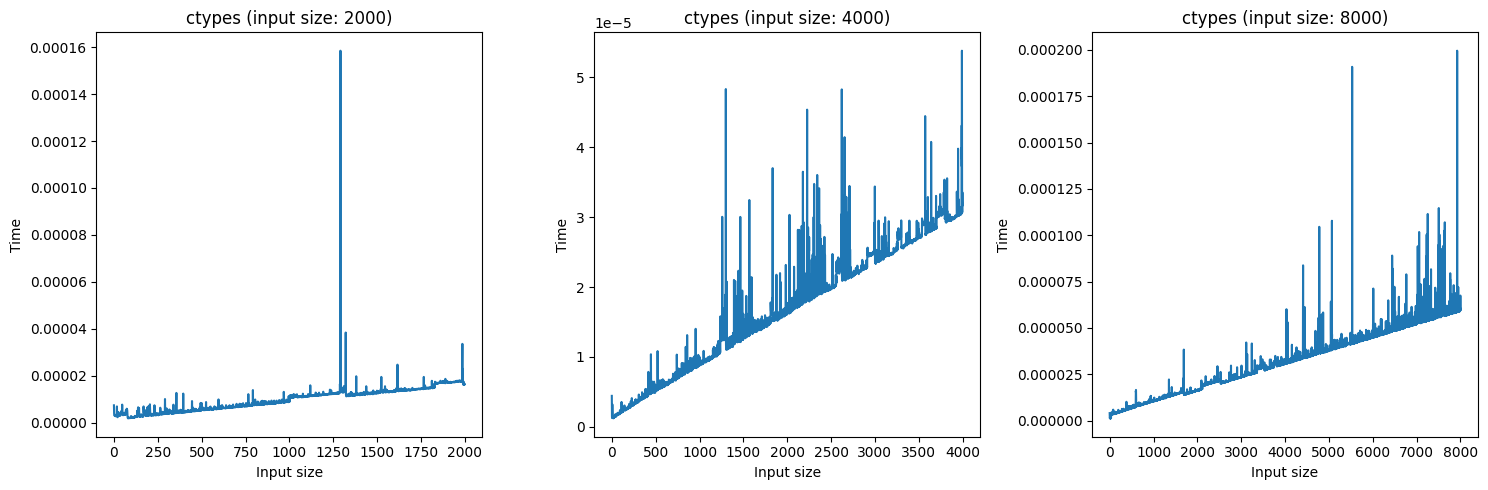

In [4]:
plot_tc_single_fn(lib.euclidean_distance, populate_array, "ctypes")

## `Cython`
Es una librería que hace "traducciones" de `Python` a `C/C++` (o viceversa) y generá un código en `C` que tendrá que ser compilado a una librería dinámica para poder hacer uso de las funciones que se implementen en `C/C++`.

Es, a su vez, un lenguaje de programación que usa sintaxis de los lenguajes de programación en cuestión, que funciona como un "mediador" entre estos lenguajes.

```Cython
from libcpp.vector cimport vector

# Declare the C++ functions
cdef extern from "lib.cpp":
    double euclidean_distance(const vector[double]& vec1, const vector[double]& vec2)

# Use the C++ function from Python
def calculate_euclidean_distance(double[:] arr1, double[:] arr2):
    """Calculates the Euclidean distance between two double vectors."""
    cdef vector[double] cpp_vec1
    cdef vector[double] cpp_vec2

    # Create Cython memoryviews for efficient access
    cdef double[:] memview1 = arr1
    cdef double[:] memview2 = arr2

    for i in range(len(arr1)):
        cpp_vec1.push_back(memview1[i])
        cpp_vec2.push_back(memview2[i])

    return euclidean_distance(cpp_vec1, cpp_vec2)
```

In [8]:
import tmp.lib as libcy
import numpy as np  # Import NumPy for array conversion

# Create the list
t1 = [1, 2]
t2 = [3, 4]

# Convert the list to a NumPy array (compatible with memoryview)
nt1 = np.array(t1, dtype=np.float64)
nt2 = np.array(t2, dtype=np.float64)

# Create a memoryview from the NumPy array
mt1 = memoryview(nt1)
mt2 = memoryview(nt2)

# Call the Cython function with the memoryview
result = libcy.calculate_euclidean_distance(mt1, mt2)
print(f"The sum of the elements is: {result}")

# Auxiliar function for plotting
def cython_euclidean_distance(p, q, s):
    return libcy.calculate_euclidean_distance(p, q)

The sum of the elements is: 2.8284271247461903


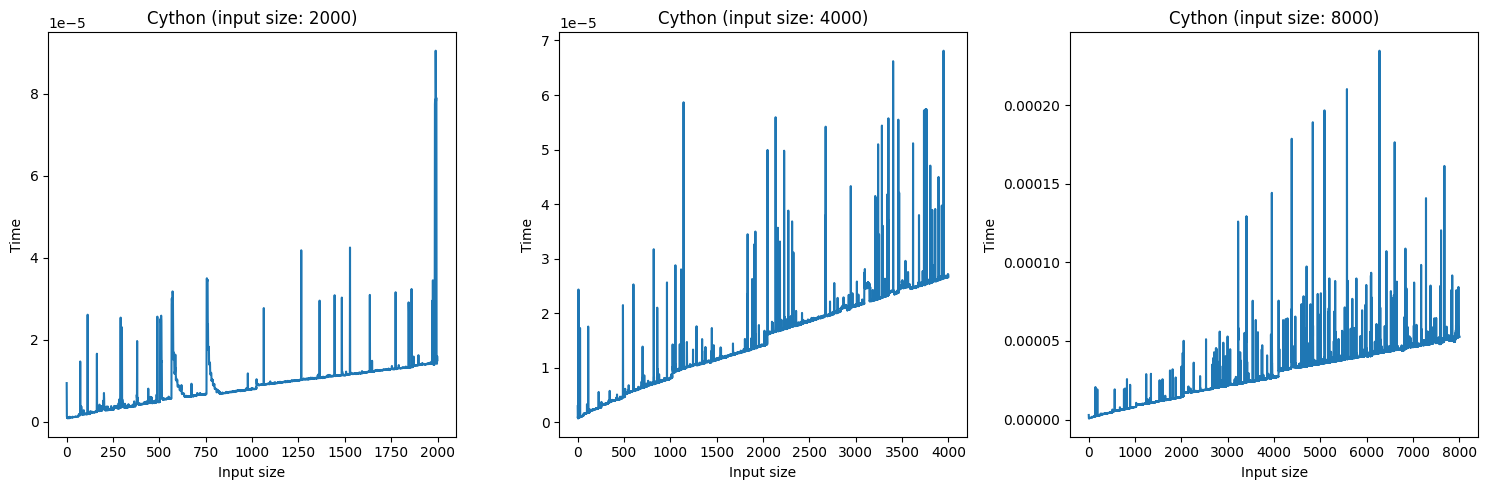

In [14]:
plot_tc_single_fn(cython_euclidean_distance, populate_vector, "Cython")